In [1]:
import numpy as np

import os
import jax 
import jax.numpy as jnp

from diffrax import diffeqsolve, ODETerm, LinearInterpolation, SaveAt, PIDController, Tsit5
from functools import partial

# PLOTTING
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.style.use('spiffy')
from spiffyplots import MultiPanel

EPSILON = 1e-8

# Local imports
from src.core.activation import SoftReLu

In [2]:
# limit jax memory usage
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.8'

# Functions and classes

In [3]:
class NonLinearDaleFeedbackControl():
    """
    Simple network with a single hidden layer.
    For use in a student-teacher setting with ongoing synaptic plasticity and time-dependent inputs.
    """
    def __init__(self,
                 actE,
                 actI,
                 k_p, 
                 k_i,
                 lamda,
                 tau_E,
                 tau_I,
                 tau_C,
                 tau_W,
                 tau_Q,
                 Q_norm,
                 dim_input,
                 dim_hidden,
                 dim_output,
                 learning_rule,
                 y0
                 ) -> None:
        
        self.actE = actE
        self.actI = actI
        self.k_p = k_p
        self.k_i = k_i
        self.lamda = lamda
        self.tau_E = tau_E
        self.tau_I = tau_I
        self.tau_C = tau_C
        self.tau_w = tau_W
        self.tau_Q = tau_Q
        self.Q_norm = Q_norm
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden
        self.dim_output = dim_output
        
        self.learning_rule = learning_rule
        self.y0 = y0
        
    
    def _compute_jacobian(self, state):

        dydu2exc = jnp.diag(self.actE.deriv(state['u'][1]['exc']))
        Q2 = dydu2exc * jnp.diag(self.actI.deriv(state['u'][1]['inh'])) 
        dydu1exc = jnp.dot(dydu2exc, state['w'][1].T) * self.actE.deriv(state['u'][0]['exc'].reshape(1, -1))
        Q1 = dydu1exc * self.actI.deriv(state['u'][0]['inh'].reshape(1, -1))
        
        # normalize feedback weights
        Q1 = Q1 / jnp.linalg.norm(Q1) * self.Q_norm
        Q2 = Q2 / jnp.linalg.norm(Q2) * self.Q_norm
        
        return [Q1, Q2]
        
        
    def _get_inital_state(self, rngkey, scale=2.0):
        """
        Get initial state vector & weights
        """
        state = {}
        key1, key2, key3, key4 = jax.random.split(rngkey, 4)
        
        # Dynamics
        state['u'] = [
            {'exc': jnp.zeros(self.dim_hidden),
             'inh': jnp.zeros(self.dim_hidden)},
            {'exc': jnp.zeros(self.dim_output),
             'inh': jnp.zeros(self.dim_output)}
        ]
        
        # Controller
        state['c_int'] = jnp.zeros(self.dim_output)
        
        # Weights
        w1 = jax.random.normal(key1, (self.dim_input, self.dim_hidden)) * scale/jnp.sqrt(self.dim_input)
        w2 = jax.random.normal(key2, (self.dim_hidden, self.dim_output)) * scale/jnp.sqrt(self.dim_hidden)
        state['w'] = [w1, w2]
        
        # Bias
        b1 = jax.random.normal(key3, (self.dim_hidden,)) * scale/jnp.sqrt(self.dim_hidden)
        b2 = jax.random.normal(key4, (self.dim_output,)) * scale/jnp.sqrt(self.dim_output)
        state['b'] = [b1, b2]
        
        # Feedback weights
        state['q'] = self._compute_jacobian(state)
        
        return state
    
    
    def burn_in(self, t, state, inputs):
        """
        Burn-in period to learn feedback weights
        (No weight updates or biases)
        """
        
        update_u = []
        update_q = []
        
        state_u, weights, bias, fb_weights = state['u'], state['w'], state['b'], state['q']

        # Get input
        x = inputs.evaluate(t)
        
        # Get jacobian
        jac = self._compute_jacobian(state)
    
        # Update dynamics        
        h = x
        for l in range(2):
            u_exc = state_u[l]['exc']
            r_exc = self.actE(u_exc)
            u_inh = state_u[l]['inh']
            r_inh = self.actI(u_inh)
            w = weights[l]
            b = bias[l]
            q = fb_weights[l]
            
            du_exc = 1 / self.tau_E * (- u_exc + jnp.dot(h, w) + b - r_inh)
            du_inh = 1 / self.tau_I * (- u_inh + r_exc)
            
            update_u.append({'exc': du_exc, 'inh': du_inh})
            
            h = r_exc        
            
            # Update feedback weights
            dQ = 1 / self.tau_Q * (-q + jac[l])
            update_q.append(dQ)
            
        # Zero updates for weights / biases / controller
        update = {'u': update_u,
                  'w': [jnp.zeros_like(weights[0]), jnp.zeros_like(weights[1])], 
                  'b': [jnp.zeros_like(bias[0]), jnp.zeros_like(bias[1])],
                  'c_int': jnp.zeros_like(state['c_int']),
                  'q': update_q}
            
        return update
        
    
    def eval(self, t, state, inputs):
        """
        Forward pass without weight updates and without control
        """
        
        update_u = []
        state_u, weights, bias = state['u'], state['w'], state['b']

        # Get input
        x = inputs.evaluate(t)
    
        # Update dynamics        
        h = x
        for l in range(2):
            u_exc = state_u[l]['exc']
            r_exc = self.actE(u_exc)
            u_inh = state_u[l]['inh']
            r_inh = self.actI(u_inh)
            w = weights[l]
            b = bias[l]
            
            du_exc = 1 / self.tau_E * (- u_exc + jnp.dot(h, w) + b - r_inh)
            du_inh = 1 / self.tau_I * (- u_inh + r_exc)
            
            update_u.append({'exc': du_exc, 'inh': du_inh})
            
            h = r_exc        
            
        # Zero updates for weights / biases / controller
        update = {'u': update_u,
                  'w': [jnp.zeros_like(weights[0]), jnp.zeros_like(weights[1])], 
                  'b': [jnp.zeros_like(bias[0]), jnp.zeros_like(bias[1])],
                  'c_int': jnp.zeros_like(state['c_int']),
                  'q': [jnp.zeros_like(state['q'][0]), jnp.zeros_like(state['q'][1])]}
            
        return update
    
    
    def eval_with_control(self, t, state, inputs, targets):
        """
        Forward pass without weight updates but with control
        """

        update = {}
                
        # Get input and target
        x = inputs.evaluate(t)
        y = targets.evaluate(t)
        
        # Update controller
        y_pred = self.out(state)
        e = y - y_pred
        c = self.k_p * e + self.k_i * state['c_int']
        c_int = state['c_int']        
        update['c_int'] = 1 / self.tau_C * (e - self.lamda * c_int)
    
        # Update dynamics
        update['u'] = []

        h = x
        for l in range(2):
            u_exc = state['u'][l]['exc']
            r_exc = self.actE(u_exc)
            u_inh = state['u'][l]['inh']
            r_inh = self.actI(u_inh)
            w = state['w'][l]
            q = state['q'][l]
            b = state['b'][l]
            du_exc = 1 / self.tau_E * (- u_exc + jnp.dot(h, w) + b - r_inh )
            du_inh = 1 / self.tau_I * (- u_inh + r_exc - jnp.dot(c, q))
            update['u'].append({'exc': du_exc, 'inh': du_inh})
            
            h = r_exc        
            
        # Do not update weights, biases, FB weights
        update['w'] = [jnp.zeros_like(state['w'][0]), jnp.zeros_like(state['w'][1])]
        update['b'] = [jnp.zeros_like(state['b'][0]), jnp.zeros_like(state['b'][1])]
        update['q'] = [jnp.zeros_like(state['q'][0]), jnp.zeros_like(state['q'][1])]
        
        return update
    
    
    def train(self, t, state, inputs, targets):
        """
        Forward pass with feedback control and learning
        """
        
        update = {'u': [],
                  'w': [],
                  'b': [],
                  'q': []}
                  
                
        # Get input and target
        x = inputs.evaluate(t)
        y = targets.evaluate(t)

        # Get jacobian
        jac = self._compute_jacobian(state)

        # Update controller
        y_pred = self.out(state)
        e = y - y_pred
        c = self.k_p * e + self.k_i * state['c_int']
        c_int = state['c_int']        
        update['c_int'] = 1 / self.tau_C * (e - self.lamda * c_int)
    
        # Update dynamics

        pre = x
        for l in range(2):
            u_exc = state['u'][l]['exc']
            r_exc = self.actE(u_exc)
            u_inh = state['u'][l]['inh']
            r_inh = self.actI(u_inh)
            w = state['w'][l]
            q = state['q'][l]
            b = state['b'][l]
            du_exc = 1 / self.tau_E * (- u_exc + jnp.dot(pre, w) + b - r_inh )
            du_inh = 1 / self.tau_I * (- u_inh + r_exc - jnp.dot(c, q))
            update['u'].append({'exc': du_exc, 'inh': du_inh})
                        
            # Update feedback weights
            dQ = 1 / self.tau_Q * (-q + jac[l])
            update['q'].append(dQ) 
            
            # update weights and biases
            if self.learning_rule == 'exact':
                error = (r_exc - u_inh) * self.actE.deriv(r_exc)
            elif self.learning_rule == 'approx':
                error = (r_exc - self.actE.inv_lin_taylor(u_inh, self.y0)) * self.actE.deriv(r_exc)
            else:
                raise ValueError('Learning rule not recognized')
            
            update['b'].append(1 / self.tau_w * error)
            update['w'].append(1 / self.tau_w * jnp.outer(pre, error))
            
            # Update pre
            pre = r_exc        
            
        return update
    
    def out(self, state):
        return self.actE(state['u'][-1]['exc'])



In [4]:
class Trainer():
    
    def __init__(self,
                 network,
                 solver,
                 stepsize_controller,
                 t0, 
                 t1,
                 dt,
                 
                 ) -> None:
        
        self.network = network
        self.solver = solver
        self.stepsize_controller = stepsize_controller
        
        self.t0 = t0
        self.t1 = t1
        self.dt = dt
        self.time = jnp.arange(t0, t1, dt)
        
    @partial(jax.jit, static_argnums=(0))
    def eval(self, state, inputs):
        
        inp = LinearInterpolation(self.time, inputs)
        
        def f(t, state, etc):
            return self.network.eval(t, state, inp)
        
        odeterm = ODETerm(f)
        sol = diffeqsolve(odeterm, 
                          self.solver, 
                          y0=state, 
                          t0=self.t0, 
                          t1=self.t1, 
                          dt0=self.dt,
                          saveat=SaveAt(ts=self.time),
                          stepsize_controller=self.stepsize_controller
                          )
        
        y_pred = self.network.out(sol.ys)
        final_state = jax.tree_map(lambda x: x[-1], sol.ys)

        return y_pred, sol, final_state

    @partial(jax.jit, static_argnums=(0))
    def eval_with_control(self, state, inputs, targets):
        
        inp = LinearInterpolation(self.time, inputs)
        tar = LinearInterpolation(self.time, targets)

        def f(t, state, etc):
            return self.network.eval_with_control(t, state, inp, tar)
        
        odeterm = ODETerm(f)
        sol = diffeqsolve(odeterm, 
                          self.solver, 
                          y0=state, 
                          t0=self.t0, 
                          t1=self.t1, 
                          dt0=self.dt,
                          saveat=SaveAt(ts=self.time),
                          stepsize_controller=self.stepsize_controller
                          )
        
        y_pred = self.network.out(sol.ys)
        final_state = jax.tree_map(lambda x: x[-1], sol.ys)

        return y_pred, sol, final_state
    
    @partial(jax.jit, static_argnums=(0))
    def eval_combined(self, state, inputs, targets):
            
        inp = LinearInterpolation(self.time, inputs)
        target = LinearInterpolation(self.time, targets)

        # First half: without control
        time_OL = jnp.arange(self.t0, self.t1/2, self.dt)
        
        def f(t, state, etc):
            return self.network.eval(t, state, inp)
        
        odeterm = ODETerm(f)
        sol_OL = diffeqsolve(odeterm, 
                          self.solver, 
                          y0=state, 
                          t0=self.t0, 
                          t1=self.t1 / 2, 
                          dt0=self.dt,
                          saveat=SaveAt(ts=time_OL),
                          stepsize_controller=self.stepsize_controller
                          )
        

        # Second half: with control
        time_CL = jnp.arange(self.t1/2, self.t1, self.dt)
        state['u'] = jax.tree_map(lambda x: x[-1], sol_OL.ys['u'])

        def f(t, state, etc):
            return self.network.eval_with_control(t, state, inp, target)

        odeterm = ODETerm(f)
        sol_CL = diffeqsolve(odeterm, 
                          self.solver, 
                          y0=state, 
                          t0=self.t1 / 2, 
                          t1=self.t1, 
                          dt0=self.dt,
                          saveat=SaveAt(ts=time_CL),
                          stepsize_controller=self.stepsize_controller
                          )
        
        # Tree_map to concatenate solutions along time axis
        y_pred = self.network.out(jax.tree_map(lambda x, y: jnp.concatenate((x, y), axis=0), sol_OL.ys, sol_CL.ys))
        ts = jnp.concatenate((sol_OL.ts, sol_CL.ts), axis=0)
        
        return y_pred, ts, sol_OL, sol_CL
    

    @partial(jax.jit, static_argnums=(0))
    def train(self, state, inputs, targets):
        
        inp = LinearInterpolation(self.time, inputs)
        target = LinearInterpolation(self.time, targets)

        def f(t, state, etc):
            return self.network.train(t, state, inp, target)
        
        odeterm = ODETerm(f)
        sol = diffeqsolve(odeterm, 
                          self.solver, 
                          y0=state, 
                          t0=self.t0, 
                          t1=self.t1, 
                          dt0=self.dt,
                          saveat=SaveAt(ts=self.time),
                          stepsize_controller=self.stepsize_controller
                          )
        
        y_pred = self.network.out(sol.ys)
        final_state = jax.tree_map(lambda x: x[-1], sol.ys)
        
        return y_pred, sol, final_state
    
    @partial(jax.jit, static_argnums=(0))
    def burn_in(self, state, inputs):
        
        inp = LinearInterpolation(self.time, inputs)

        def f(t, state, etc):
            return self.network.burn_in(t, state, inp)
        
        odeterm = ODETerm(f)
        sol = diffeqsolve(odeterm, 
                          self.solver, 
                          y0=state, 
                          t0=self.t0, 
                          t1=self.t1, 
                          dt0=self.dt,
                          saveat=SaveAt(ts=self.time),
                          stepsize_controller=self.stepsize_controller
                          )
        
        # returns final state
        final_state = jax.tree_map(lambda x: x[-1], sol.ys)
        
        return final_state

    def least_control_loss(self, sol, target):
        state = sol.ys
        # VMAP _least_control_loss over time dimension (first dimension) of both state and raw_target
        return jnp.mean(jax.vmap(self._least_control_loss, in_axes=(0, 0))(state, target))
    
    def _least_control_loss(self, state, target):
            
            y_pred = self.network.out(state)
            e = target - y_pred
            c = self.network.k_p * e + self.network.k_i * state['c_int']
            Q1, Q2 = state['q']
            cQ1 = jnp.dot(c, Q1)
            cQ2 = jnp.dot(c, Q2)
            return jnp.sum(cQ1**2) + jnp.sum(cQ2**2)
    
    def mse_loss(self, y_pred, target):
        return jnp.mean(jnp.sum((y_pred - target)**2, axis=-1))
    

In [5]:
@jax.jit
def generate_sinewaves(t, amp, freq, phase=0):
    """
    :param t:       time vector
    :param amp:     n-dimensional vector with amplitudes
    :param freq:    n-dimensional vector with frequencies
    :param phase:   n-dimensional vector with phase shifts
    
    
    :returns        n-by-t dimensional matrix with sine waves

    """

    tfreq = jnp.dot(jnp.expand_dims(t, -1), jnp.expand_dims(freq, 0))

    return amp.T * jnp.sin(2 * jnp.pi * tfreq + phase.T)

def generate_random_sinewaves(t, N, rngkey, 
                              freq_min = 0.1, freq_max = 2,
                              amp_min = 0.1, amp_max = 1.0,
                              phase_min = 0, phase_max = jnp.pi):
    
    key1, key2, key3 = jax.random.split(rngkey, 3)
    
    amp = jax.random.uniform(key1, shape=(N,), minval=amp_min, maxval=amp_max)
    freq = jax.random.uniform(key2, shape=(N,), minval=freq_min, maxval=freq_max)
    phase = jax.random.uniform(key3, shape=(N,), minval=phase_min, maxval=phase_max)
        
    return generate_sinewaves(t, amp, freq, phase)


# Parameters

In [6]:
# Dynamics
actE = SoftReLu(5.0, 1.0, 3.0)
actI = SoftReLu(1.0, 1.0, 3.0)
k_p = 30.0
k_i = 15.0
lamda = 0.5
tau_E = 20e-3
tau_I = 5e-3
tau_C = 100e-3
tau_W = 60
tau_Q = 30

# Feedback weights
Q_norm = 7.5

# Architecture
dim_input = 30
student_dim_hidden = 20
teacher_dim_hidden = 20
dim_output = 2

# Numerical solver
t0 = 0
t1 = 5
dt = 1e-3
solver = Tsit5()
stepsize_controller = PIDController(rtol=1e-3, 
                                    atol=1e-6,
                                    pcoeff=0.1, 
                                    icoeff=0.3, 
                                    dcoeff=0.1,
                                    dtmin=dt / 10,
                                    dtmax=10 * dt,
                                    factormin=0.1,
                                    factormax=2)


# Initialization
w_scale_teacher = 2.0
w_scale_student = 2.0

# Learning
nb_epochs_burn_in = 4
nb_epochs_train = 60

y0 = 0.5        # linearization point for approximate learning rule

# Random seed
seed = 2
key = jax.random.PRNGKey(seed)
key_input, key_student, key_teacher = jax.random.split(key, 3)


### Plotting parameters

In [7]:
colors_input = ['gray', 'black']
color_trace = '#00C9B3'
color_controller = '#E09F26'
colors_loss = {'linear': 'black',
               'exact': 'gray',
               'CL': 'black'}


# Generate inputs and networks

### Networks

In [8]:
teacher_net = NonLinearDaleFeedbackControl(actE,
                                       actI, 
                                       k_p, 
                                       k_i, 
                                       lamda, 
                                       tau_E, 
                                       tau_I,
                                       tau_C, 
                                       tau_W, 
                                       tau_Q, 
                                       Q_norm,
                                       dim_input,
                                       teacher_dim_hidden,
                                       dim_output,
                                       'none',
                                       y0)

teacher_state = teacher_net._get_inital_state(key_teacher, w_scale_teacher)

student_net_exact = NonLinearDaleFeedbackControl(actE,
                                       actI,
                                       k_p, 
                                       k_i, 
                                       lamda, 
                                       tau_E, 
                                       tau_I,
                                       tau_C, 
                                       tau_W, 
                                       tau_Q, 
                                       Q_norm,
                                       dim_input,
                                       student_dim_hidden,
                                       dim_output,
                                       'exact',
                                       y0)

student_state_exact = student_net_exact._get_inital_state(key_student, w_scale_student)

student_net_approx = NonLinearDaleFeedbackControl(actE,
                                       actI,
                                       k_p, 
                                       k_i, 
                                       lamda, 
                                       tau_E, 
                                       tau_I,
                                       tau_C, 
                                       tau_W, 
                                       tau_Q, 
                                       Q_norm,
                                       dim_input,
                                       student_dim_hidden,
                                       dim_output,
                                       'approx',
                                       y0)

student_state_approx= student_net_approx._get_inital_state(key_student, w_scale_student)


### Trainers

In [9]:
teacher = Trainer(teacher_net, solver, stepsize_controller, t0, t1, dt)
student_exact = Trainer(student_net_exact, solver, stepsize_controller, t0, t1, dt)
student_approx = Trainer(student_net_approx, solver, stepsize_controller, t0, t1, dt)

# 1. Teacher & Student burn-in period

In [10]:
start_t = t0
end_t = t1

for e in range(nb_epochs_burn_in):

    print("Burn-in epoch {}".format(e))

    time = jnp.arange(start_t, end_t, dt)
    input = generate_random_sinewaves(time, dim_input, key_input)
    
    student_state_approx = student_approx.burn_in(student_state_approx, input)
    student_state_exact = student_exact.burn_in(student_state_exact, input)
    teacher_state = teacher.eval(teacher_state, input)[-1]
    
    start_t += t1
    end_t += t1

Burn-in epoch 0
Burn-in epoch 1
Burn-in epoch 2
Burn-in epoch 3


# 2. Evaluation before training

For plotting purposes, plots one epoch worth of targets & student output (with & without control) before training. We do not advance the running `time` because this will be the first epoch used for training

In [11]:
PLOT_inputs = generate_random_sinewaves(time, dim_input, key_input)
PLOT_targets = teacher.eval(teacher_state, PLOT_inputs)[0]
PLOT_y_pred_before, PLOT_ts, _, _ = student_approx.eval_combined(student_state_approx, 
                                                                        PLOT_inputs, 
                                                                        PLOT_targets)

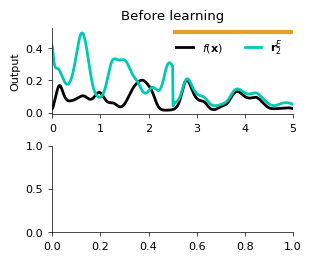

In [12]:
fig = MultiPanel(grid=[1, 1], figsize=(3, 2.5))

# before learning
fig.panels[0].set_title('Before learning')

fig.panels[0].plot(PLOT_ts, PLOT_targets[:, 1], color='black', lw=2, label=r'$f(\mathbf{x})$')
fig.panels[0].plot(PLOT_ts, PLOT_y_pred_before[:, 1], color=color_trace, lw=2, label=r'$\mathbf{r}_2^E$')

# Line indicating the time when the controller is active
fig.panels[0].hlines(0.5, t1/2, t1, color=color_controller, linewidth=3)

fig.panels[0].set_ylabel('Output')
fig.panels[0].set_xlim([t0, t1])

# add legend but separate entries horizontally instead of vertically
fig.panels[0].legend(loc='upper right',
                        ncol=2,
                        frameon=False,
                        fontsize=8,
                        handlelength=1.5)

plt.show()

# 3. Training

Training loop which updates state, weights, feedback weights etc. simulateneously

In [13]:
loss_exact = {'OL': [], 'CL': [], 'LCL': []}
loss_approx = {'OL': [], 'CL': [], 'LCL': []}

for epoch in range(nb_epochs_train):
    
    print("\n")
    print("Training epoch {}".format(epoch))

    time = jnp.arange(start_t, end_t, dt)
    
    # Get inputs
    input = generate_random_sinewaves(time, dim_input, key_input)
    
    # Get targets
    targets, _ , teacher_state = teacher.eval(teacher_state, input)
    
    # APPROXIMATE LEARNING RULE STUDENT
    y_pred_eval, _, _ = student_approx.eval(student_state_approx, 
                                            input)
    y_pred_ctrl, sol, student_state_approx = student_approx.train(student_state_approx, 
                                                                  input, 
                                                                  targets)

    loss_OL = student_approx.mse_loss(y_pred_eval, targets)
    loss_CL = student_approx.mse_loss(y_pred_ctrl, targets)
    loss_LCL = student_approx.least_control_loss(sol, targets)
    
    loss_approx['OL'].append(loss_OL)
    loss_approx['CL'].append(loss_CL)
    loss_approx['LCL'].append(loss_LCL)
    
    print("Approx - MSE Loss (OL): ", loss_OL)
    print("Approx - MSE Loss (CL): ", loss_CL)
    print('Approx - LCL: ', loss_LCL)

    # EXACT LEARNING RULE STUDENT
    y_pred_eval, _, _ = student_exact.eval(student_state_exact, 
                                            input)
    y_pred_ctrl, sol, student_state_exact = student_exact.train(student_state_exact, 
                                                                  input, 
                                                                  targets)

    loss_OL = student_exact.mse_loss(y_pred_eval, targets)
    loss_CL = student_exact.mse_loss(y_pred_ctrl, targets)
    loss_LCL = student_exact.least_control_loss(sol, targets)
    
    loss_exact['OL'].append(loss_OL)
    loss_exact['CL'].append(loss_CL)
    loss_exact['LCL'].append(loss_LCL)
    
    print("Exact - MSE Loss (OL): ", loss_OL)
    print("Exact - MSE Loss (CL): ", loss_CL)
    print('Exact - LCL: ', loss_LCL)
    
    start_t += t1
    end_t += t1
    



Training epoch 0
Approx - MSE Loss (OL):  5.264478
Approx - MSE Loss (CL):  0.0012327376
Approx - LCL:  82.98541
Exact - MSE Loss (OL):  5.264478
Exact - MSE Loss (CL):  0.0012377813
Exact - LCL:  86.86559


Training epoch 1
Approx - MSE Loss (OL):  1.5288918
Approx - MSE Loss (CL):  0.0005674014
Approx - LCL:  46.06329
Exact - MSE Loss (OL):  2.9760065
Exact - MSE Loss (CL):  0.00064743526
Exact - LCL:  57.8122


Training epoch 2
Approx - MSE Loss (OL):  0.40197185
Approx - MSE Loss (CL):  0.00043355717
Approx - LCL:  32.34796
Exact - MSE Loss (OL):  1.6316317
Exact - MSE Loss (CL):  0.000531579
Exact - LCL:  47.076866


Training epoch 3
Approx - MSE Loss (OL):  0.08338577
Approx - MSE Loss (CL):  0.0007551575
Approx - LCL:  35.42065
Exact - MSE Loss (OL):  0.70705044
Exact - MSE Loss (CL):  0.00076358917
Exact - LCL:  45.544342


Training epoch 4
Approx - MSE Loss (OL):  0.034455735
Approx - MSE Loss (CL):  0.00044515828
Approx - LCL:  28.30481
Exact - MSE Loss (OL):  0.3614552
Exa

# 4. Evaluation after training

In [14]:
# Repeat burn-in periods to get same initial conditions as before training

start_t = t0
end_t = t1

for e in range(nb_epochs_burn_in):

    print("Burn-in epoch {}".format(e))

    time = jnp.arange(start_t, end_t, dt)
    input = generate_random_sinewaves(time, dim_input, key_input)
    
    student_state_approx = student_approx.eval(student_state_approx, input)[-1]
    student_state_exact = student_exact.eval(student_state_exact, input)[-1]
    teacher_state = teacher.eval(teacher_state, input)[-1]
    
    start_t += t1
    end_t += t1

Burn-in epoch 0
Burn-in epoch 1
Burn-in epoch 2
Burn-in epoch 3


In [15]:
# Evaluate on same inputs as before training
PLOT_y_pred_after, _, _, _ = student_approx.eval_combined(student_state_approx, PLOT_inputs, PLOT_targets)

# Plotting

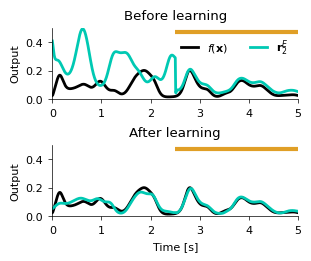

In [16]:

fig = MultiPanel(grid=[1, 1], figsize=(3, 2.5))

# before learning
fig.panels[0].set_title('Before learning')

fig.panels[0].plot(PLOT_ts, PLOT_targets[:, 1], color='black', lw=2, label=r'$f(\mathbf{x})$')
fig.panels[0].plot(PLOT_ts, PLOT_y_pred_before[:, 1], color=color_trace, lw=2, label=r'$\mathbf{r}_2^E$')

# Line indicating the time when the controller is active
fig.panels[0].hlines(0.47, t1/2, t1, color=color_controller, linewidth=3)

fig.panels[0].set_ylim([0, 0.5])
fig.panels[0].set_ylabel('Output')
fig.panels[0].set_xlim([t0, t1])

# add legend but separate entries horizontally instead of vertically
fig.panels[0].legend(loc='upper right',
                        ncol=2,
                        frameon=False,
                        fontsize=8,
                        handlelength=1.5)

fig.panels[1].set_title('After learning')

fig.panels[1].plot(PLOT_ts, PLOT_targets[:, 1], color='black', lw=2, label=r'$f(\mathbf{x})$')
fig.panels[1].plot(PLOT_ts, PLOT_y_pred_after[:, 1], color=color_trace, lw=2, label=r'$\mathbf{r}_2^E$')

# Line indicating the time when the controller is active
fig.panels[1].hlines(0.47, t1/2, t1, color=color_controller, linewidth=3)

fig.panels[1].set_ylim([0, 0.5])
fig.panels[1].set_ylabel('Output')
fig.panels[1].set_xlim([0, t1])
fig.panels[1].set_xlabel('Time [s]')

plt.show()

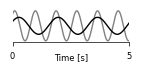

In [17]:
# Plot example inputs
input_ts = jnp.arange(0, t1, dt)
fig, ax = plt.subplots(figsize=(1.3, 0.6))
ax.plot(input_ts, PLOT_inputs[:,0], lw=1, color=colors_input[0])
ax.plot(input_ts, PLOT_inputs[:,1], lw=1, color=colors_input[1])

# Plot X label and ticks
# Move X label closer to the axis
ax.set_xlabel('Time [s]', fontsize=6, labelpad=-6)

ax.set_xlim([0, t1])
ax.set_xticks([0, t1])
ax.set_xticklabels(['0', t1], fontsize=6)

# remove y axis ticks
ax.set_yticks([])
ax.spines['left'].set_visible(False)

plt.show()

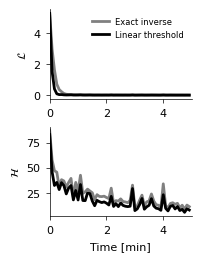

In [18]:
# Plot loss curves
t_loss = nb_epochs_train * t1 
timevec = np.arange(0, t_loss, t1) / 60

fig = MultiPanel(grid=[1, 1], figsize=(1.9, 2.5))

fig.panels[0].plot(timevec, loss_exact['OL'], lw=2, color=colors_loss['exact'], label='Exact inverse')
fig.panels[0].plot(timevec, loss_approx['OL'], lw=2, color=colors_loss['linear'], label='Linear threshold')

fig.panels[0].set_ylabel(r'$\mathcal{L}$')
fig.panels[0].legend(loc='upper right', fontsize=6, frameon=False)
fig.panels[0].set_xlim([0, t_loss/60])
#fig.panels[0].set_yscale('log')

fig.panels[1].plot(timevec, loss_exact['LCL'], lw=2, color=colors_loss['exact'])
fig.panels[1].plot(timevec, loss_approx['LCL'], lw=2, color=colors_loss['linear'])
#fig.panels[1].plot(timevec, loss_exact['LCL'], lw=2, color=colors_loss['exact'])

fig.panels[1].set_xlabel('Time [min]')
fig.panels[1].set_ylabel(r'$\mathcal{H}$')
#fig.panels[1].set_yscale('log')

fig.panels[1].set_xlim([0, t_loss/60])


plt.show()